<a href="https://colab.research.google.com/github/DrakeWagner/Python_Data_Science_Class_Projects/blob/master/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 5012 Mini Project
Benjamin Feciura / bmf3bw

Drake Wagner / dbw2tn

Rehan Merchant / rm2bt

Our database concerns the players, teams, coaches, stadiums, and matches of Major League Soccer (MLS) in the United States. Using the information related to each of these entities, we feel we can query, compare within, and aggregate a number of interesting variables.

## Creating the Database Structure

### Tables:
**team**(<u>teamID</u>, name, city)

**player**(<u>name, team, number</u>, position)

**coach**(<u>team</u>, name, nationality)

**stadium**(<u>home_team</u>, name, city, surface_type, capacity)

**match**(<u>date, home_team, away_team</u>, stadium, home_team_score, away_team_score)

### Relations:

**scores_goal**(<u>match.date, match.home_team, match.away_team, player.name, player.number, player.team</u>, time)

**commits foul**(<u>match.date, match.home_team, match.away_team, player.name, player.number, player.team</u>, time, card)

![ER Diagram](ERDiagram.png)

In [ ]:
import sqlite3

In [ ]:
conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()

In [ ]:
# create team table
cursor.execute('''create table team(
                teamID text,
                name text,
                city text,
                primary key (teamID))''')

In [ ]:
# create player table
cursor.execute('''create table player(
                name text,
                team text,
                number int,
                position text,
                primary key (name, team, number),
                foreign key (team) references team(teamID))''')

In [ ]:
# create coach table
cursor.execute('''create table coach(
                name text,
                team text,
                nationality text,
                primary key (team),
                foreign key (team) references team(teamID))''')

In [ ]:
# create stadium table
cursor.execute('''create table stadium(
                name text,
                city text,
                home_team text,
                surface_type text,
                capacity int,
                primary key (home_team),
                foreign key (home_team) references team(teamID))''')

In [ ]:
# create match table
cursor.execute('''create table match(
                home_team text,
                away_team text,
                date date,
                home_team_score int,
                away_team_score int,
                attendance int,
                primary key (date, home_team, away_team),
                foreign key (home_team) references stadium(home_team),
                foreign key (away_team) references team(teamID))''')

In [ ]:
# create commits_foul relation table
cursor.execute('''create table commits_foul(
                player text,
                number int,
                team text,
                match_date date,
                home_team text,
                away_team text,
                time int,
                card text,
                primary key (time, match_date, home_team, away_team),
                foreign key (player, number, team) references player(name, number, team),
                foreign key (match_date, home_team, away_team) references match(date, home_team, away_team))''')

In [ ]:
# create scores_goal relation table
cursor.execute('''create table scores_goal(
                player text,
                number int,
                team text,
                match_date date,
                home_team text,
                away_team text,
                time int,
                primary key (time, match_date, home_team, away_team),
                foreign key (player, number, team) references player(name, number, team),
                foreign key (match_date, home_team, away_team) references match(date, home_team, away_team))''')

## Input data into database
### Web scraping

In [ ]:
# scrape list of teams from MLS website, with links to rosters and team info

import requests
from bs4 import BeautifulSoup
import pandas as pd

clublist_url = "https://www.mlssoccer.com/clubs/"
clublist = requests.get(clublist_url)
clublist_soup = BeautifulSoup(clublist.content, 'html5lib')

In [ ]:
# collect data for players in a dataframe

playerdata = pd.DataFrame(columns = ["Name", "Team", "Number", "Position"])
club_names = []
club_ids = []
import json

for element in clublist_soup.find_all('div', {'class': 'mls-o-clubs-hub-clubs-list__club-name'}):
    club_names.append(element.contents[1].contents[0])

for element in clublist_soup.find_all('div', {'class': 'mls-o-clubs-hub-clubs-list__club-links'}):
    roster_url = "https://www.mlssoccer.com" + element.contents[1].attrs['href'] + "roster/"
    roster = requests.get(roster_url)
    roster_soup = BeautifulSoup(roster.content, 'html5lib')
    
    for element in roster_soup.find_all('section', {'class': "mls-l-module mls-l-module--active-roster"}):
        club_info = json.loads(element["data-options"])
        for player in club_info["playersData"]:
            name = player["fullName"]
            team = club_info["clubAbbreviation"]
            number = player["jerseyNumber"]
            position = player["position"]
            playerdata = playerdata.append(pd.DataFrame([[name, team, number, position]], columns = ["Name", "Team", "Number", "Position"]))
            
    club_ids.append(club_info["clubAbbreviation"])
        
playerdata.reset_index(inplace=True)

In [ ]:
# use dataframe to populate database

for i in range(len(playerdata)):
    if i == 510: # there is a duplicate value in this row
        continue
    sql = '''insert into player
             (name, team, number, position)
             values
             (:name, :team, :number, :position)'''
    cursor.execute(sql, {'name':playerdata["Name"][i], 'team':playerdata["Team"][i], 'number':playerdata["Number"][i], 'position':playerdata["Position"][i]})
    
    conn.commit()

In [ ]:
# manually create list of home cities (not easily accessible on MLS website)

cities = ["Atlanta", "Austin", "Chicago", "Cincinnati", "Denver", "Columbus", "Washington", "Dallas", "Houston", "Kansas City", "Los Angeles", "Los Angeles", "Miami", "Saint Paul", "Montreal", "Nashville", "Boston", "New York", "New York", "Orlando", "Philadelphia", "Portland", "Salt Lake City", "San Jose", "Seattle", "Toronto", "Vancouver"]

In [ ]:
# create dataframe of team data using data collected during last step

teamdata = pd.DataFrame()
teamdata["TeamID"] = club_ids
teamdata["Name"] = club_names
teamdata["City"] = cities

In [ ]:
# use dataframe to populate database

for i in range(len(teamdata)):
    sql = '''insert into team
             (teamID, name, city)
             values
             (:teamID, :name, :city)'''
    cursor.execute(sql, {'teamID':teamdata["TeamID"][i], 'name':teamdata["Name"][i], 'city':teamdata["City"][i]})
    
    conn.commit()

In [ ]:
# scrape list of stadiums from Wikipedia

stadium_url = "https://en.wikipedia.org/wiki/List_of_Major_League_Soccer_stadiums"
stadium = requests.get(stadium_url)
stadium_soup = BeautifulSoup(stadium.content, 'html5lib')

In [ ]:
# Collect stadium data in a dataframe

stadiumdata = pd.DataFrame(columns = ["name", "home_team", "city", "surface_type", "capacity"])

tr_list = stadium_soup.find_all('table')[1].find_all('tr')
for i in range(1,len(tr_list)):
    name = tr_list[i].contents[3].contents[0].contents[0]
    home_team = tr_list[i].contents[5].contents[0].string
    city = tr_list[i].contents[7].contents[0].contents[0].split(",")[0]
    surface_type = tr_list[i].contents[15].contents[0].string
    capacity = tr_list[i].contents[11].contents[0]
    
    stadiumdata = stadiumdata.append(pd.DataFrame([[name, home_team, city, surface_type, capacity]], columns = ["name", "home_team", "city", "surface_type", "capacity"]))
    
stadiumdata.reset_index(inplace=True, drop=True)  

In [ ]:
# Create a dictionary to convert full team name to team ID 
# (this teamID is abbreviation used as primary key in post tables)

teamname_abbrev = {}
for i in range(len(teamdata)):
    teamname_abbrev[teamdata["Name"][i]] = teamdata["TeamID"][i]
# some team name styles differ; add manually
teamname_abbrev["Minnesota United FC"] = "MIN"
teamname_abbrev["Los Angeles FC"] = "LAFC"
teamname_abbrev["Orlando City SC"] = "ORL"
teamname_abbrev["Atlanta United FC"] = "ATL"
teamname_abbrev["CF Montréal"] = "MTL"

# Use dataframe and dictionary to populate dataframe

for i in range(len(stadiumdata)):
    sql = '''insert into stadium
             (name, home_team, city, surface_type, capacity)
             values
             (:name, :home_team, :city, :surface_type, :capacity)'''
    cursor.execute(sql, {'name':stadiumdata["name"][i], 'home_team':teamname_abbrev[stadiumdata["home_team"][i]], 'city':stadiumdata["city"][i], 'surface_type':stadiumdata["surface_type"][i], 'capacity':stadiumdata["capacity"][i]})
    
    conn.commit()

In [ ]:
# Scrape coach data from Wikipedia

coaches_url = "https://en.wikipedia.org/wiki/List_of_Major_League_Soccer_coaches"
coaches = requests.get(coaches_url)
coaches_soup = BeautifulSoup(coaches.content, 'html5lib')

In [ ]:
# Collect coach data in a dataframe

coachlist = coaches_soup.find_all('table')[0].find_all('tr')

coachdata = pd.DataFrame(columns = ["name", "team", "nationality"])

for i in range(1,len(coachlist)):
    name = coachlist[i].contents[1].string
    nationality = coachlist[i].contents[3].contents[1].string
    team = coachlist[i].contents[7].string
    
    coachdata = coachdata.append(pd.DataFrame([[name, team, nationality]], columns = ["name", "team", "nationality"]))

coachdata.reset_index(inplace=True, drop=True)   

In [ ]:
# Use dataframe and dictionary to populate database

for i in range(len(coachdata)):
    sql = '''insert into coach
             (name, team, nationality)
             values
             (:name, :team, :nationality)'''
    cursor.execute(sql, {'name':coachdata["name"][i], 'team':teamname_abbrev[coachdata["team"][i]], 'nationality':coachdata["nationality"][i]})
    
    conn.commit()

### Manual Entry

We have been unable to find an adequate source from which to scrape data about individual matches, so this data will be input manually using DB Browser.

## Queries

**When inputting game data, it seemed to me that the second half often contained many more events than the first half. Is this true? I'll compare both scores and penalties.**

In [ ]:
# number of scores in the first half vs second

for row in cursor.execute('''
                            select count(time)
                            from scores_goal
                            where time < 45''').fetchall():
    print(row)

print()
for row in cursor.execute('''
                            select count(time)
                            from scores_goal
                            where time >= 45''').fetchall():
    print(row)

(10,)

(11,)


We can see that in total among the 8 games in our database, the same number of goals were scored in the first halves as in the second halves.

In [ ]:
# number of penalties in the first half vs second

for row in cursor.execute('''
                            select count(time)
                            from commits_foul
                            where time < 45''').fetchall():
    print(row)

print()
for row in cursor.execute('''
                            select count(time)
                            from commits_foul
                            where time >= 45''').fetchall():
    print(row)

(5,)

(19,)


Conversely, we can see that in these games, fouls were far more likely to be committed in the second half as compared to the first.

**I also noticed that jersey numbers are often repeated, sometimes even among players on the same team. Which ones are the most common?**

In [ ]:
# Which jersey numbers are most common?
import pandas as pd

jersey_count = pd.DataFrame(cursor.execute('''
                            select number, count(*)
                            from player
                            group by number
                            order by count(*)''').fetchall(), columns = ["Jersey Number", "Count"]).set_index("Jersey Number")

We see 17 and 22 are the most common jersey numbers (25 players currently in the league wear each of these).

<AxesSubplot:xlabel='Jersey Number'>

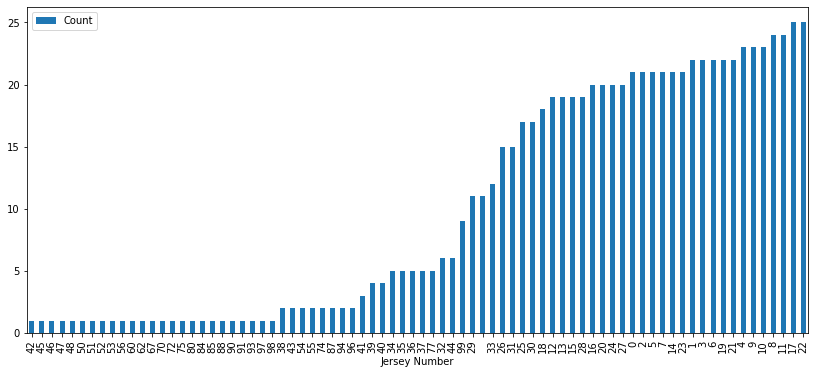

In [ ]:
jersey_count.plot.bar(figsize = (14,6))

Additionally, lower numbers are far more common than higher ones (numbers in above 40 are rarely, if ever, repeated, excluding 99).

**Which stadiums have the highest capacity?**

**Which players are coached by American coaches?**

**Which of the teams beginning with "A" played on the first day of the season? Which were most attended?**

In [ ]:
import matplotlib.pyplot as plt

sql1 = 'SELECT stadium.capacity, stadium.city, stadium.home_team, stadium.name, \
stadium.surface_type, team.name FROM stadium INNER JOIN team ON stadium.home_team = team.teamID ORDER BY stadium.capacity DESC LIMIT 6'

result = cursor.execute(sql1)
all_stads = result.fetchall()

stad_df = pd.DataFrame(all_stads, columns = ['capacity', 'city', 'home_team', 'stadium_name', 'surface_type', 'team_name'])
print(stad_df)


sql2 = 'SELECT coach.name AS coach_name, coach.team, player.name AS player_name, player.number \
FROM coach \
INNER JOIN player ON player.team = coach.team \
WHERE coach.nationality = "United States"'
result = cursor.execute(sql2)
all_usa_coach = result.fetchall()

usa_coach_df = pd.DataFrame(all_usa_coach)
print(usa_coach_df)

# Only matches of teams starting with A and on february 29th, 2020
sql3 = '''SELECT home_team, away_team, attendance \
FROM match \
WHERE home_team like 'A%' or away_team like 'A%' \
ORDER BY attendance DESC'''

result = cursor.execute(sql3)
select_matches = result.fetchall()

sel_mat_df = pd.DataFrame(select_matches)
print(sel_mat_df)

  capacity        city home_team                stadium_name  surface_type  \
0   42,500     Atlanta       ATL       Mercedes-Benz Stadium     FieldTurf   
1   37,722     Seattle       SEA                 Lumen Field     FieldTurf   
2   32,250  Cincinnati       CIN             Nippert Stadium    Act Global   
3   30,321       Bronx       NYC              Yankee Stadium         Grass   
4   30,000     Toronto       TOR                   BMO Field  Hybrid grass   
5   27,000      Carson        LA  Dignity Health Sports Park         Grass   

             team_name  
0       Atlanta United  
1  Seattle Sounders FC  
2        FC Cincinnati  
3     New York City FC  
4           Toronto FC  
5            LA Galaxy  
                 0    1                    2   3
0    Freddy Juarez  RSL        Aaron Herrera  22
1       Josh Wolff  ATX     Aaron Schoenfeld  13
2     Caleb Porter  CLB      Aboubacar Keita  30
3     Robin Fraser  COL    Abraham Rodriguez  28
4      Bruce Arena   NE          

Text(0.5, 1.0, 'Stadium Capacity by City')

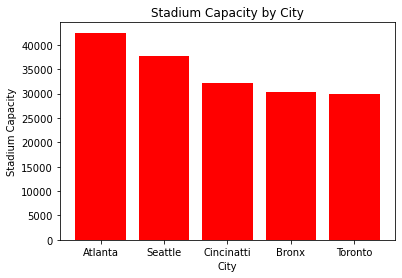

In [ ]:
list(stad_df.columns)
pd.DataFrame.head(stad_df)
cities = ['Atlanta', 'Seattle', 'Cincinatti', 'Bronx', 'Toronto']
values = [42500, 37722, 32250, 30321, 30000]
# stad_df = stad_df.iloc[1:]
# stad_df['capacity'] = pd.to_numeric(stad_df['capacity'])
plt.bar(cities, values, color='red')
plt.xlabel('City')
plt.ylabel('Stadium Capacity')
plt.title('Stadium Capacity by City')

The largest stadiums by capacity are in Atlanta, Seattle, Cincinatti, New York, and Toronto.

365 of the 773 league players are coached by Americans (just under half)!

Atlanta was the only "A" team to play on this day (against Nashville), and 59069 people attended!

**List the roster for Philadelphia Union.**

In [ ]:
Q1 = "SELECT player.name, player.position,player.team, team.name FROM player INNER JOIN team ON team.teamID = player.team WHERE team = 'PHI'"
resultQ1 = cursor.execute(Q1)
all_players_philly = resultQ1.fetchall()

philly_team_df = pd.DataFrame(all_players_philly,columns = ['Name','Position','Team','Team Name'])
print(philly_team_df)

                         Name    Position Team           Team Name
0                  Leon Flach  Midfielder  PHI  Philadelphia Union
1              Stuart Findlay    Defender  PHI  Philadelphia Union
2                Jack Elliott    Defender  PHI  Philadelphia Union
3              Quinn Sullivan  Midfielder  PHI  Philadelphia Union
4              Nathan Harriel    Defender  PHI  Philadelphia Union
5             Paxten Aaronson  Midfielder  PHI  Philadelphia Union
6               Brandan Craig  Midfielder  PHI  Philadelphia Union
7                Jack McGlynn  Midfielder  PHI  Philadelphia Union
8               Jakob Glesnes    Defender  PHI  Philadelphia Union
9                Matej Oravec  Midfielder  PHI  Philadelphia Union
10              José Martínez  Midfielder  PHI  Philadelphia Union
11                Cole Turner  Midfielder  PHI  Philadelphia Union
12              Jack De Vries  Midfielder  PHI  Philadelphia Union
13            Jamiro Monteiro  Midfielder  PHI  Philadelphia U

**Which teams scored the most goals (on February 29, 2020, the day of matches we chose to include in our database)?**

                 Team Name Team  # of goals
0           Atlanta United  ATL           2
1          Colorado Rapids  COL           2
2                FC Dallas  DAL           2
3              D.C. United   DC           1
4        Houston Dynamo FC  HOU           1
5                LA Galaxy   LA           1
6              CF Montréal  MTL           2
7   New England Revolution   NE           1
8             Nashville SC  NSH           1
9     San Jose Earthquakes   SJ           2
10    Sporting Kansas City  SKC           3
11              Toronto FC  TOR           2
12  Vancouver Whitecaps FC  VAN           1


<AxesSubplot:title={'center':'Number of Goals Scored by Team'}, xlabel='Team'>

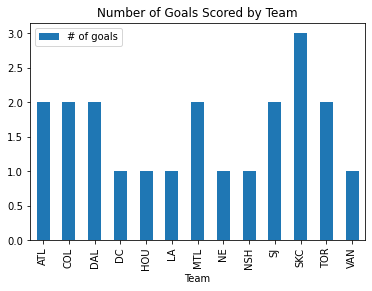

In [ ]:
Q2 = "SELECT team.name, scores_goal.team, count(scores_goal.team)FROM scores_goal INNER JOIN team WHERE scores_goal.team = team.teamID GROUP By team.teamID "
resultQ2 = cursor.execute(Q2)
team_goals = resultQ2.fetchall()
    
team_goals_df = pd.DataFrame(team_goals,columns = ['Team Name','Team','# of goals'])
print(team_goals_df)
team_goals_df.plot.bar(x='Team',y='# of goals', title = 'Number of Goals Scored by Team')

Sporting Kansas City scored the most goals on the first day (3).

**Which DC United players committed fouls?**

In [ ]:
# Who has committed a foul for DC United? 
Q3 = "SELECT commits_foul.player, commits_foul.team, count(commits_foul.player),commits_foul.card FROM commits_foul WHERE commits_foul.team = 'DC' GROUP By commits_foul.player"
resultQ3 = cursor.execute(Q3)
dc_penalties = resultQ2.fetchall()

dc_penalty_df = pd.DataFrame(dc_penalties,columns = ['Name','Team','# of Penalties','Card Color'])
print(dc_penalty_df)

dc_penalty_df.plot.bar(x='Team',y='# of Penalties', title = 'Number of Penalties by Team')

                Name Team  # of Penalties Card Color
0  Frédéric Brillant   DC               1          Y
1        Joseph Mora   DC               1          Y
2      Júnior Moreno   DC               1          Y


Frédéric Brillant, Joseph Mora, and Júnior Moreno committed fouls.

In [ ]:
cursor.close()